In [43]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
import sqlite3

In [44]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [45]:
path_to_db = '/Users/romina/Databases/aflw/data/aflw.sqlite'
path_to_imgs = '/Users/romina/Databases/aflw/data/flickr/'
path_to_positives = '/Users/romina/Documents/Masters/pos_training/'
path_to_tmp = '/Users/romina/Documents/Masters/tmp/'

In [101]:
conn = sqlite3.connect(path_to_db)
c = conn.cursor()
c.execute("""select Faces.face_id, Faces.file_id,x,y,w,h
from FacePose 
join Faces on FacePose.face_id = Faces.face_id
join FaceRect on FacePose.face_id = FaceRect.face_id
where abs(FacePose.yaw * 180/3.14159) <= 10
and abs(FacePose.roll * 180/3.14159) <= 20
and abs(FacePose.pitch * 180/3.14159) <= 20
and Faces.file_id != 'image21068.jpg'
        LIMIT 100""")
results = c.fetchall()

In [102]:
print(results[0:5])

[(39355, 'image00144.jpg', 160, 223, 645, 645), (39379, 'image00347.jpg', 463, 28, 471, 471), (39480, 'image01120.jpg', 179, -18, 268, 268), (39484, 'image01243.jpg', 92, 72, 421, 421), (39547, 'image01828.jpg', 270, 113, 686, 686)]


In [48]:
len(results)

100

In [49]:
fname_index = 1 
x_index = 2
y_index = 3
width_index = 4
height_index = 5

In [50]:
np.array(results[3][x_index:height_index+1],dtype=np.float32).reshape(-1,2)

array([[  92.,   72.],
       [ 421.,  421.]], dtype=float32)

In [51]:
def show_bbs(image, bb):
    """show image with bounding box"""
    plt.imshow(image)
    plt.scatter([bb[0], bb[0], bb[0]+bb[2], bb[0]+bb[2]], [bb[1],bb[1]+bb[3],bb[1],bb[1]+bb[3]],marker='.', c='r')
    plt.pause(0.001)

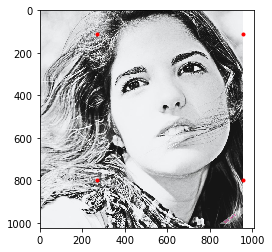

In [52]:
i = 4
plt.figure()
show_bbs(io.imread(os.path.join(path_to_tmp, results[i][fname_index])),(results[i][x_index],results[i][y_index],results[i][width_index],results[i][height_index]))
plt.show()

In [103]:
to_remove = []
for tup in results:
    try:
        io.imread(os.path.join(path_to_tmp, tup[fname_index]))
    except:
        to_remove.append(tup[fname_index])
        
print(to_remove)

[]


results = (face_id, face_index, bounding box coords)

In [81]:
class FaceBBsDataset(Dataset):
    """Face bounding boxes dataset"""
    def __init__(self, results, root_dir, transform=None):
        """
        Args:
            results(list of tuples): see above for format
            root_dir(string): dir with all images
        """
        self.image_bbs= results
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.image_bbs)
    
    def __getitem__(self, idx):
#         print('idx_original',idx_original)
#         if idx_original >= len(self.image_bbs): idx = idx_original - len(self.image_bbs)
#         else: idx = idx_original
#         print('idx',idx)
        img_name = os.path.join(self.root_dir, self.image_bbs[idx][fname_index])
        
        try:
            image = io.imread(img_name)
            bbs = np.array(self.image_bbs[idx][x_index:height_index+1],dtype=np.float32)
            bbs.reshape(-1,2)

            sample = {'image':image, 'bb': bbs}

#             if idx_original < len(self.image_bbs):
            if self.transform:
                sample = self.transform(sample)
#             else:

            return sample
        except:
            blank_image = np.zeros((10,10,3), np.uint8)
            sample = {'image': blank_image, 'bb': np.array([0,0,10,10])}
            if self.transform:
                sample = self.transform(sample)
            return sample

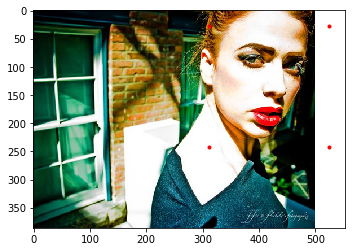

In [82]:
frontal_dataset = FaceBBsDataset(results, root_dir=path_to_tmp)
fig = plt.figure() 
# for i in range(len(frontal_dataset)):
sample = frontal_dataset[5]
show_bbs(sample['image'], sample['bb'])
    

0 (1024, 767, 3) (4,)
1 (643, 1024, 3) (4,)
2 (281, 500, 3) (4,)
3 (800, 534, 3) (4,)


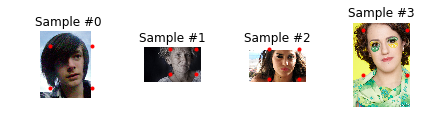

In [83]:
fig = plt.figure()
for i in range(len(frontal_dataset)):
    sample = frontal_dataset[i]
    print(i,sample['image'].shape, sample['bb'].shape)
    
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbs(**sample)
    
    if i == 3:
        plt.show()
        break

In [84]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    
    yA = max(boxA[1], boxB[1])
    yB = min(boxA[1]+boxA[2], boxB[1]+boxB[2])
    
    # compute the area of intersection rectangle
    interArea = abs((xB - xA + 1) * (yB - yA + 1))
    #     print(interArea)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    #     print(boxAArea)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou


In [85]:
class CropFace(object):
    """Crops region containing face in an image in a sample
        Args:
            output_size(tuple or int): desired output size"""
#     def __init__(self):
#         assert isinstance(output_size, (int,tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size
    
    def __call__(self, sample):
        image, bb = sample['image'], sample['bb']
        h, w = int(bb[3]), int(bb[2])
        left, top = int(max(bb[0],0)), int(max(bb[1],0))
        
        face = image[top: top + h, left: left + w]
        
        return {'x': face, 'y': 1} 
        

In [86]:
class RandomNonFaceCrop(object):
    """crop a random part of image that is < 0.3 
    IOU with face"""
#     def __init__(self):
    def __call__(self,sample):
        image, bb = sample['image'], sample['bb']
        im_h, im_w = image.shape[:2]
        face_h, face_w = int(bb[3]), int(bb[2])
        
        top = np.random.randint(0, im_h - face_h)
        left = np.random.randint(0, im_w - face_w)
    
        comp = iou(bb, (top,left,face_w,face_h))
        count = 0
        while comp > 0.3 and count <= 5:
            top = np.random.randint(0, im_h - face_h)
            left = np.random.randint(0, im_w - face_w)
            comp = iou(bb, (top,left,face_w,face_h))
            count += 1
        
        if comp > 0.3 and count > 5:
            image_cropped = image[top: top + face_h, left: left + face_w]
            return {'x': image_cropped, 'y': 1}
        else:
            image_cropped = image[top: top + face_h, left: left + face_w]
            return {'x': image_cropped, 'y': 0}
        

In [87]:
class Rescale(object):
    """rescale image in sample to a given size
    args:
        output_size (tuple or int)"""
    
    def __init__(self,output_size):
        assert isinstance(output_size, (int,tuple))
        self.output_size = output_size
        
    def __call__(self,sample):
        x, y = sample['x'], sample['y']
        h, w = x.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(x, (new_h, new_w))
        return {'x': img, 'y': y}

In [88]:
class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    def __call__(self,sample):
        x, y = sample['x'], sample['y']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #not face
        if y == 0: y_new = np.array([0, 1])
        #face
        if y == 1: y_new = np.array([1, 0])
            
        image = x.transpose((2, 0, 1))
        return {'x': torch.from_numpy(image),
                'y': torch.from_numpy(y_new)}

In [89]:
crop_face = CropFace()
crop_nonface = RandomNonFaceCrop()
scale = Rescale(100)
composed_f = transforms.Compose([CropFace(), Rescale(100)])
composed_n = transforms.Compose([RandomNonFaceCrop(), Rescale(100)])

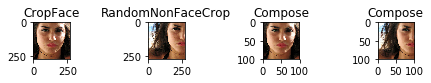

In [90]:
fig = plt.figure()
sample = frontal_dataset[2]
show_bbs(sample['image'], sample['bb'])
for i, tsfrm in enumerate([crop_face, crop_nonface, composed_f, composed_n]):
#     print(transformed_sample.keys())
#     print(sample.keys())
    transformed_sample = tsfrm(sample)
#     print(transformed_sample)
#     print(sample)
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['x'])
plt.show()

In [91]:
transformed_dataset_face = FaceBBsDataset(results, 
                                     root_dir=path_to_tmp,
                                    transform=transforms.Compose([
                                        CropFace(), 
                                        Rescale((224,224)),
                                        ToTensor()
                                    ]))
transformed_dataset_nonface = FaceBBsDataset(results, 
                                     root_dir=path_to_tmp,
                                    transform=transforms.Compose([
                                        RandomNonFaceCrop(), 
                                        Rescale((224,224)),
                                        ToTensor()
                                    ]))

In [92]:
print(len(transformed_dataset_face))
# print(len(transformed_dataset_nonface))

100


In [93]:
for i in range(20,len(transformed_dataset_face)):
    try:
        sample = transformed_dataset_face[i]
        print(i,sample['x'].size(), sample['y'])
        if i == 6:
            break
    except:
        print('oops')

20 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

21 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

22 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

23 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

24 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

25 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

26 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

27 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

28 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

29 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

30 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

31 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

32 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

33 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

34 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

35 torch.S

In [94]:
for i in range(len(transformed_dataset_nonface)):
    sample = transformed_dataset_nonface[i]
    print(i,sample['x'].size(), sample['y'])
    if i == 6:
        break

0 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

1 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

2 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

3 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

4 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

5 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

6 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]



In [95]:
train_

NameError: name 'train_' is not defined

In [96]:
print(len(transformed_dataset_face))

100


In [97]:
dataloader = DataLoader(transformed_dataset_face, 
                        batch_size=4,
                       shuffle=True, num_workers=2)

In [98]:
list(dataloader)

[{'x': 
  ( 0 , 0 ,.,.) = 
    0.0018  0.0025  0.0017  ...   0.0039  0.0037  0.0079
    0.0000  0.0000  0.0017  ...   0.0039  0.0039  0.0121
    0.0000  0.0000  0.0017  ...   0.0026  0.0070  0.0019
             ...             ⋱             ...          
    0.5447  0.6202  0.6174  ...   0.6323  0.6297  0.6280
    0.4060  0.5341  0.6189  ...   0.6316  0.6322  0.6367
    0.5255  0.3960  0.6094  ...   0.6380  0.6365  0.6328
  
  ( 0 , 1 ,.,.) = 
    0.0018  0.0025  0.0017  ...   0.0039  0.0028  0.0112
    0.0000  0.0000  0.0017  ...   0.0039  0.0041  0.0199
    0.0000  0.0000  0.0017  ...   0.0026  0.0036  0.0092
             ...             ⋱             ...          
    0.5996  0.6751  0.6723  ...   0.7098  0.7081  0.7064
    0.4570  0.5853  0.6698  ...   0.7098  0.7104  0.7151
    0.5792  0.4508  0.6630  ...   0.7125  0.7111  0.7104
  
  ( 0 , 2 ,.,.) = 
    0.0018  0.0025  0.0017  ...   0.0039  0.0059  0.0058
    0.0000  0.0000  0.0017  ...   0.0039  0.0010  0.0029
    0.0000  0.000

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])


Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x11e49d7b8>>
Traceback (most recent call last):
  File "/Users/romina/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._shutdown_workers()
  File "/Users/romina/anaconda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 237, in _shutdown_workers
    self.index_queue.put(None)
  File "/Users/romina/anaconda/lib/python3.6/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/Users/romina/anaconda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/romina/anaconda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/romina/anaconda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: 

5 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
6 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
7 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
8 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
9 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
10 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
11 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
12 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
13 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
14 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
15 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
16 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
17 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
18 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
19 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
20 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
21 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
22 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
23 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
24 torch.Size([4, 3, 224, 224]) torc

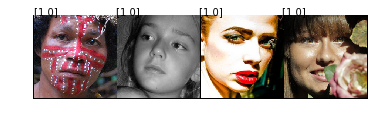

In [100]:
def show_batch(sample_batched):
    """Show image and label for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['x'], sample_batched['y']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
#         plt.label(labels_batch[i,:])
        plt.text(224*i,0.65,labels_batch[i,:].numpy())

for i_batch, sample_batched in enumerate(dataloader):
    try:
        print(i_batch, sample_batched['x'].size(),
              sample_batched['y'].size())

        # observe 4th batch and stop.
        if i_batch == 24:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break
    except:
        print('oops')